In [698]:
# %qtconsole

In [699]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split

In [700]:
def rmsle(predicted, real):
    sum=0.0
    for x in range(len(predicted)):
        p = np.log(predicted[x]+1)
        r = np.log(real[x]+1)
        sum = sum + (p - r)**2
    return (sum/len(predicted))**0.5

In [701]:
odf = pd.read_csv("./data/train.tsv", delimiter='\t', 
                      low_memory=False)

In [702]:
odf.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [703]:
# preprocess
from sklearn import preprocessing

def preprocess(strList):
    ret = stringify(strList)
    return labelEncode(ret)

def labelEncode(strList):
    le = preprocessing.LabelEncoder()
    ret = le.fit_transform(strList)
    return ret

def stringify(strList):
    ret = [str(unicode(str(x), errors="ignore")).strip().lower() for x in strList]
    return ret

def extractToken(x, n, delim='/'):
    arr = str(x).split(delim)
    if (len(arr)>n):
        return arr[n]
    else:
        return None

In [704]:

odf.category_name = stringify(odf.category_name)
odf['category_1'] = [extractToken(x, 0) for x in odf.category_name]
odf['category_2'] = [extractToken(x, 1) for x in odf.category_name]
odf['category_3'] = [extractToken(x, 2) for x in odf.category_name]

df = odf.drop(['train_id', 'category_name'], axis=1)
df.name = preprocess(df.name)
df.brand_name = preprocess(df.brand_name)
df.item_description = preprocess(df.item_description)

df.category_1 = labelEncode(df.category_1)
df.category_2 = labelEncode(df.category_2)
df.category_3 = labelEncode(df.category_3)

In [705]:
df.head()

,name,item_condition_id,brand_name,price,shipping,item_description,category_1,category_2,category_3
0,671539,3,3043,10.0,1,812395,5,102,763
1,869279,3,3615,52.0,0,1126949,1,31,213
2,135053,1,4242,10.0,1,115877,10,103,95
3,544762,1,3043,35.0,1,783915,3,55,404
4,44976,1,3043,44.0,0,377714,10,59,536


In [706]:
y = df.price
# X = df.drop('price', axis=1)
X_train, X_test, y_train, y_test = train_test_split(
     df, y, test_size=0.33, random_state=42)
print X_train.shape, X_test.shape

(993298, 9) (489237, 9)


In [707]:
#groupByCols = ['category_name', 'item_condition_id']
groupByCols = ['category_1', 'category_2', 'category_3']

avgPrice = X_train.groupby(by=groupByCols)['price'].mean()
avgPrice.name = 'avgPrice'

X_train = X_train.join(avgPrice, on=groupByCols)
X_test = X_test.join(avgPrice, on=groupByCols)

print X_train.shape, X_test.shape

(993298, 10) (489237, 10)


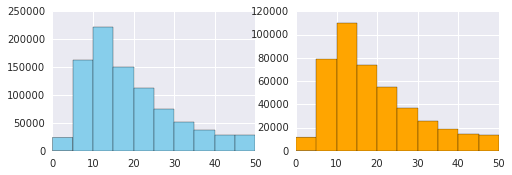

In [712]:
plt.subplot(221)
plt.hist(y_train[y_train<np.percentile(y_train, 90)], color='skyblue')
plt.subplot(222)
plt.hist(y_test[y_test<np.percentile(y_test, 90)], color='orange')

plt.show()

In [713]:
X_test.loc[X_test.avgPrice.isnull(),'avgPrice'] = np.median(X_train.avgPrice)

In [714]:
X_train = X_train.drop('price', axis=1)
X_test = X_test.drop('price',axis=1)

In [715]:
from sklearn.ensemble import RandomForestRegressor
regr = RandomForestRegressor(max_depth=150, n_estimators=20, random_state=0)
regr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=150,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=20, n_jobs=1, oob_score=False, random_state=0,
           verbose=0, warm_start=False)

In [716]:
[ x[0]+' : '+ str(round(x[1],2)) for x in zip(
            X_train.columns[np.argsort(regr.feature_importances_)[::-1]].values, 
            np.sort(regr.feature_importances_)[::-1])]

['name : 0.31',
 'item_description : 0.23',
 'avgPrice : 0.18',
 'brand_name : 0.14',
 'item_condition_id : 0.04',
 'avgPrice3 : 0.02',
 'shipping : 0.02',
 'category_3 : 0.02',
 'category_2 : 0.01',
 'avgPrice2 : 0.01',
 'avgPrice1 : 0.01',
 'category_1 : 0.0']

In [717]:
y_pred = regr.predict(X_test)

In [718]:
rmsle(y_pred, y_test.values)

0.58383062120917584